# Introduction and motivation

Flache and Macy (2011), FM2011 from here forward, advance opinion dynamics modeling by running dynamical simulations on small-world networks. They build these small-world networks by randomizing two flavors of caveman graphs: the first is the initially unconnected caveman graphs, where there are $N$ nodes split into $k$ fully-connected subgraphs with no connections in between subgraphs. The other method begins with the connected caveman graph (Watts, 1999). The connected caveman is used by Flache and Macy (2011) as well as DellaPosta, et al., (2015). Our first experiments will be using the randomized connected caveman graph, using the method described in DellaPosta, et al., (2015), on pp. 1490-1491. More details can be found in the code implementation in [macy/macy.py](/edit/macy/macy.py).

We are testing some variations on the dynamics and experiments of FM2011. We will consider a different scheme for assigning neighbor weights using the cosine similarity. This may change the results that as $K$, the number of opinion features in agent opinion vectors, increases, polarization decreases. However, the distance between agent opinions contains a factor of $1/K$ that may be undesirable. The same distance appears in the calculation of the output measure of polarization. Perhaps this is not what is best for understanding the phenomena of opinion segmentation and polarization. So, we consider this alternative. The first experiment will be to compare simulations that result from

As for the experiments themselves, FM2011 only considered initial conditions where agents' opinion features were uniformly distributed across opinion space, specifically in the range $(-1, 1)$. We consider uniform distributions taken from the range $(-S, S)$, where $0 \leq S < 1$. We also consider the case where agents' opinion updating contains noise, with varying noise levels and variances. We test the effect of initial conditions and noise for various levels of cultural complexity, $K$. 

In our code, $S$ is represented by the variable `box_width`. The FM2011 experiments are recreated below, where $S=1$, there is no noise, and we set the distance measure to be `'fm2011'`. 

100% (2000 of 2000) |##########################################################################################################################| Elapsed Time: 0:00:10 Time: 0:00:10


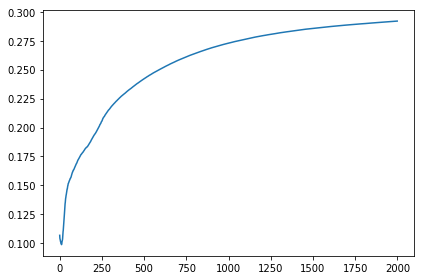

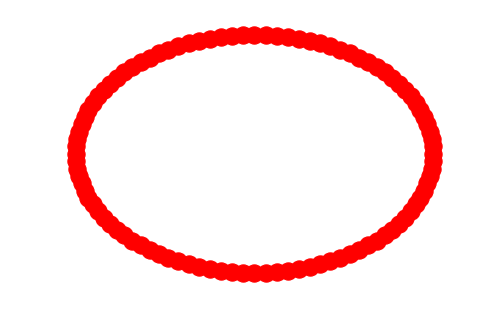

In [16]:
import warnings
warnings.filterwarnings("ignore")  # to silence tight_layout warnings

import matplotlib.pyplot as plt

from experiments.within_box import BoxedCavesExperiment

S = 1.0
noise_level = 0.0
K = 2
rewire_probability = 0.1  # need to double check this
n_caves = 20
n_per_cave = 5

# Set up experiment.
experiment = BoxedCavesExperiment(
    n_caves, n_per_cave, S, K=K
)
# experiment.setup(add_cxn_prob=0.01)
# Iterate 1000 times. Polarization is saved for each iteration.
experiment.iterate(2000, noise_level=noise_level)

h = experiment.history['polarization']
t = [el[0] for el in h]
polarization = [el[1] for el in h]
plt.plot(t, polarization)
plt.figure()
nx.draw_circular(experiment.network.graph)

100% (4000 of 4000) |##########################################################################################################################| Elapsed Time: 0:00:21 Time: 0:00:21


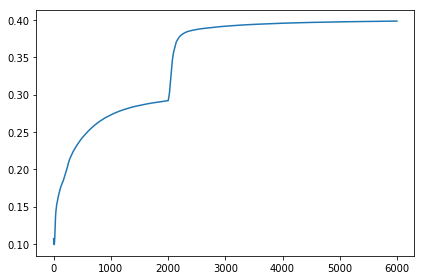

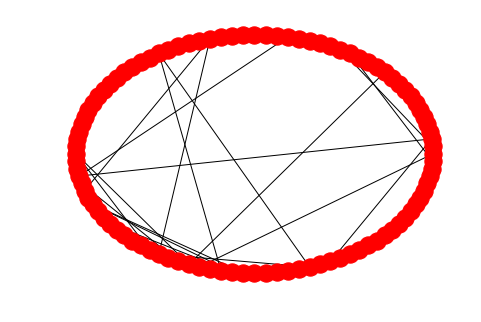

In [17]:
# Now turn on the awesome!
experiment.add_random_edges(20)
experiment.iterate(4000)
h = experiment.history['polarization']
t = [el[0] for el in h]
polarization = [el[1] for el in h]
plt.plot(t, polarization)
plt.figure()
nx.draw_circular(experiment.network.graph)

In [ ]:
coords = experiment.history['coords']
# print(list(coords[0]))
# print('# iter: {}'.format(len(coords)))
# lc0 = list(coords[0])
print('# coords in first iter: {}'.format(len(lc0)))
# lc0
# print(list(coords[-1]))
x400 = [el[0] for el in coords[400]]
y400 = [el[1] for el in coords[400]]
xlast = [el[0] for el in coords[-1]]
ylast = [el[1] for el in coords[-1]]
plt.plot(x400, y400, '.', label='400')
plt.plot(xlast, ylast, '.', label='last')
plt.legend()

In [ ]:
# Now do K=1, 2, 3, 5
def k_experiment(n_caves=20, n_per_cave=5, n_iter=100,
                 outcome_metric='fm2011', rewire_prob=0.1):
    for K in [1, 2, 3, 5]:

        experiment = BoxedCavesExperiment(
            n_caves, n_per_cave, S, K, 
            rewire_prob=rewire_prob, outcome_metric=outcome_metric
        )
#         experiment.setup(add_cxn_prob=cxn_prob)

        experiment.iterate(n_iter, noise_level=noise_level)

        h = experiment.history['polarization']
        t = [el[0] for el in h]

        polarization = [el[1] for el in h]
        plt.plot(t, polarization, label='K={}'.format(K))

    plt.legend()

In [ ]:
k_experiment(rewire_prob=0.1)

### Evaluation of reproduction of FM2011

These results are not quite matching those given in Flache and Macy (2011). $K=2$ is a little under what they report. However they don't make it clear what the probability of rewiring is for their connected caveman experiment. I'm also getting an error when rewire probability is greater than .01. Is it related? Need to check. 

Before we work to confirm that our code is working well enough, we can continue our experiments and first see what the effect is of changing the polarization measure to use Euclidian distance instead of their $K$-scaled $L_1$ distance.

Recall that polarization is defined as 

$$
P(t; K) = \frac{1}{N(N-1)} \sum_{i \neq j} (d^{FM}_{ij}(t) - \bar d(t))^2
$$

Where $\bar d(t)$ is the average "distance" between all agents 

$$
d^{FM}_{ij}(t) = \frac{1}{K} \sum_{k=1}^K \lvert s_{jk}(t) - s_{ij}(t)\rvert .
$$ 

We could call this the average absolute pairwise distance. It is a scaled version of the $L^1$ distance, also known as the Manhattan distance. It is problematic in that it decreases the distance between agents if the agents are embedded in higher-dimensional opinion spaces the agents have zero-valued opinions in these additional opinion features.

So, we will re-do these experiments, but with a different distance measure we write $d^{L^2}_{ij}(t)$, which will just be the Euclidian distance between agents $i$ and $j$.



In [ ]:
k_experiment(outcome_metric='euclidean', rewire_prob=0.1, n_iter=2000)

In [ ]:
k_experiment(outcome_metric='cityblock', rewire_prob=0.1, n_iter=500)

In [ ]:
k_experiment(20, 10, cxn_prob=0.003)

In [ ]:
k_experiment(20, 10, rewire_prob=0.1, outcome_metric='euclidean', n_iter=2000)

## The effect of cultural complexity with alternate weighting

Now that we have run the FM2011 experiments, we will replace their distance metric in the weight update equations with the cosine similarity, which we write 

$$
d^{cs}_{ij}[t] = \frac{s_i[t]^Ts_j[t]}{\lVert s_i[t] \rVert \lVert s_j[t] \rVert}
$$

## Constrained initial opinions


Here we build on Flache and Macy (2011) by considering the effect of initial opinions on final polarization.

## Noisy opinion updates

DellaPosta, D., Shi, Y., & Macy, M. (2015). Why Do Liberals Drink Lattes? American Journal of Sociology, 120(5), 1473–1511. http://doi.org/10.1086/681254

Flache, A., & Macy, M. W. (2011). Small Worlds and Cultural Polarization. The Journal of Mathematical Sociology, 35(1–3), 146–176.

Watts, D. J. (1999). Networks, Dynamics, and the Small World Phenomenon. American Journal of Sociology. http://doi.org/10.1086/210318